# Neural Networks (NNs) For Enhancer Activity Prediction

**Authorship:**
Adam Klie, *09/23/2021*
***
**Description:**
Notebook to train Neural Network (NN) classifiers for predicting enhancer activity
 - Currently supports training both RNNs and CNNs on one-hot encoded sequence input.
 - For RNNs, bidirectional, unidirectional and bidirectional w/ reverse complement are available for training
***
**TODOs:**
 - <font color='red'> Increase patience on next run </font>
 - <font color='red'> Figure out how to add loss curves to report </font>
***

# Set-up

In [1]:
# Classics
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set random seeds
np.random.seed(333)

# Figure style
plt.style.use('presentation')

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Load local libraries
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
sys.path.append('/cellar/users/aklie/projects/EUGENE/NN/')
sys.path.append('/cellar/users/aklie/bin/make_it_train/')
import project_utils
from early_stop import EarlyStop

# Deep learning time
import torch
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses
from torchinfo import summary

# Check for GPU
print("Using a GPU? {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Device number [0-7]: {}".format(torch.cuda.current_device()))
    print("Running on {} devices".format(torch.cuda.device_count()))

Using a GPU? True
Device number [0-7]: 0
Running on 1 devices


In [6]:
# Data params
DATASET = "2021_OLS_Library"  # Which dataset to look at
FEATURES = "ohe-seq"  # What features to use to train the model
LABELS = "binary"
PREPROCESS = "0.09-0.4"  # Preprocessing steps, separated by "-"
SPLIT = "training"
SUBSET = False

In [27]:
# Architecture params
HYPERPARAM = "baseline"
ARCHITECTURE = "bdsLSTM"
MAX_EPOCHS = 16
BATCH_SIZE=512
TUNE = False
EPOCHS_TRAINED = 0
PATIENCE = 3
RECURRENT = True
BIDIRECTIONAL = True

In [15]:
# Out directory
if BIDIRECTIONAL:
    OUTDIR="{}_{}_{}_{}_bi{}".format(PREPROCESS, SPLIT, FEATURES, HYPERPARAM, ARCHITECTURE)
else:
    OUTDIR="{}_{}_{}_{}".format(PREPROCESS, SPLIT, FEATURES, HYPERPARAM, ARCHITECTURE)
if not os.path.exists(OUTDIR):
    print("Making directory {}".format(OUTDIR))
    os.makedirs(OUTDIR)
else:
    print("Directory already exists")

Making directory 0.09-0.4_training_ohe-seq_baseline_bidsLSTM


# Load train and validation data

In [16]:
# Load train and val
X_train = np.load('../data/{0}/{1}/{2}_X-{3}_{4}.npy'.format(DATASET, FEATURES.replace("-", "_"), PREPROCESS, SPLIT, FEATURES))
y_train = np.loadtxt('../data/{0}/{1}/{2}_y-{3}_{1}.txt'.format(DATASET, LABELS, PREPROCESS, SPLIT), dtype=float)
                                                                         
# need to fix this in the EDA
if not RECURRENT:
    X_train = np.transpose(X_train, axes=(0, 2, 1))
print(X_train.shape, y_train.shape)

if "ds" in ARCHITECTURE:
    print("Training double stranded model, loading reverse seqs")
    X_train_rev = np.load('../data/{0}/{1}/{2}_X-{3}_{4}-rev.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, SPLIT, FEATURES))

    if not RECURRENT:
        X_train_rev = np.transpose(X_train_rev, axes=(0, 2, 1))
    print(X_train_rev.shape)

(197548, 66, 4) (197548,)
Training double stranded model, loading reverse seqs
(197548, 66, 4)


# Train a NN classifier

#### <u> **Choose the model architecture** </u> 

In [17]:
if ARCHITECTURE == "ssLSTM":
    from models import ssLSTM
    if BIDIRECTIONAL:
        print("Loading a single stranded, bidirectional LSTM model")
        eugene = ssLSTM(bidirectional=True, hidden_size=64, num_layers=3)
    else:
        print("Loading a single stranded, unidirectional LSTM model")
        eugene = ssLSTM(bidirectional=False, hidden_size=64, num_layers=3)
elif ARCHITECTURE == "dsLSTM":
    from models import dsLSTM
    if BIDIRECTIONAL:
        print("Loading a double stranded, bidirectional LSTM model")
        eugene = dsLSTM(bidirectional=True, hidden_size=64, num_layers=3)
    else:
        print("Loading a double stranded, unidirectional LSTM model")
        eugene = dsLSTM(bidirectional=False, hidden_size=64, num_layers=3)
elif ARCHITECTURE == "DeepSea":
    print("Loading a DeepSea CNN model")
    from models import DeepSea
    eugene = DeepSea(first_channels=16, second_channels=8)
else:
    print("{} is not a currently supported model architecture".format(ARCHITECTURE))
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Executing the model on:", device)

Loading a double stranded, bidirectional LSTM model
Executing the model on: cuda


In [18]:
#from models import test_dsLSTM
#eugene = test_dsLSTM(bidirectional=True, hidden_size=64, num_layers=3)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print("Executing the model on:", device)

#### <u> **Train a new model from scratch OR Tune a previously trained model** </u> 

In [19]:
# Instantiate model and move to gpu if available
if TUNE == False:
    print("Training a new model, initializing weights and tranferring to:", device)
    eugene.apply(project_utils.init_weights)
    eugene.to(device)
else:
    print("Tuning previous model at {}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, EPOCHS_TRAINED, ARCHITECTURE),)
    eugene.load_state_dict(torch.load("{}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, EPOCHS_TRAINED, ARCHITECTURE), map_location=torch.device(device)))
    eugene.to(device)

Training a new model, initializing weights and tranferring to: cuda


In [20]:
eugene

dsLSTM(
  (lstm): LSTM(4, 64, num_layers=3, batch_first=True, bidirectional=True)
  (reverse_lstm): LSTM(4, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

#### <u> **Test the load** </u> 

In [21]:
# Grab some seqs and outputs to test out on
indexes = np.random.choice(len(X_train), size=5)
random_seqs = torch.from_numpy(X_train[indexes, :, :]).float().to(device)
random_labels = torch.from_numpy(y_train[indexes]).to(device)
if "ds" in ARCHITECTURE:
    random_rev_seqs = torch.from_numpy(X_train_rev[indexes, :, :]).float().to(device)
    outputs = eugene(random_seqs, random_rev_seqs).squeeze(dim=1)
    print(outputs, random_labels, project_utils.accuracy(outputs, random_labels)/len(outputs))
    print(summary(eugene, input_size=((BATCH_SIZE, 66, 4), (BATCH_SIZE, 66, 4))))
else:
    outputs = eugene(random_seqs).squeeze(dim=1)
    print(outputs, random_labels, project_utils.accuracy(outputs, random_labels)/len(outputs))
    if RECURRENT:
        print(summary(eugene, input_size=(BATCH_SIZE, 66, 4)))
    else:
        print(summary(eugene, input_size=(BATCH_SIZE, 4, 66)))

tensor([0.0934, 0.0955, 0.0937, 0.0957, 0.0939], device='cuda:0',
       grad_fn=<SqueezeBackward1>) tensor([0., 1., 0., 1., 1.], device='cuda:0', dtype=torch.float64) 0.6
Layer (type:depth-idx)                   Output Shape              Param #
dsLSTM                                   --                        --
├─LSTM: 1-1                              [512, 66, 128]            234,496
├─LSTM: 1-2                              [512, 66, 128]            234,496
├─Linear: 1-3                            [512, 1]                  257
Total params: 469,249
Trainable params: 469,249
Non-trainable params: 0
Total mult-adds (G): 15.85
Input size (MB): 1.08
Forward/backward pass size (MB): 69.21
Params size (MB): 1.88
Estimated Total Size (MB): 72.17


#### <u> **Dataloading** </u> 

In [23]:
# Build Datasets objects from arrays
if "ds" in ARCHITECTURE:
    train_dataset = TensorDataset(torch.from_numpy(np.stack([X_train, X_train_rev], axis=3)), torch.from_numpy(y_train))
else:
    # Build Datasets objects from arrays
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))

In [24]:
# Build Loaders from the Datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
# Check dims of loaders for correctness
print("Dimensions of training set: {} x {}".format(len(train_loader.dataset), train_loader.dataset[0][0].shape))

Dimensions of training set: 197548 x torch.Size([66, 4, 2])


#### <u> **Training** </u> 

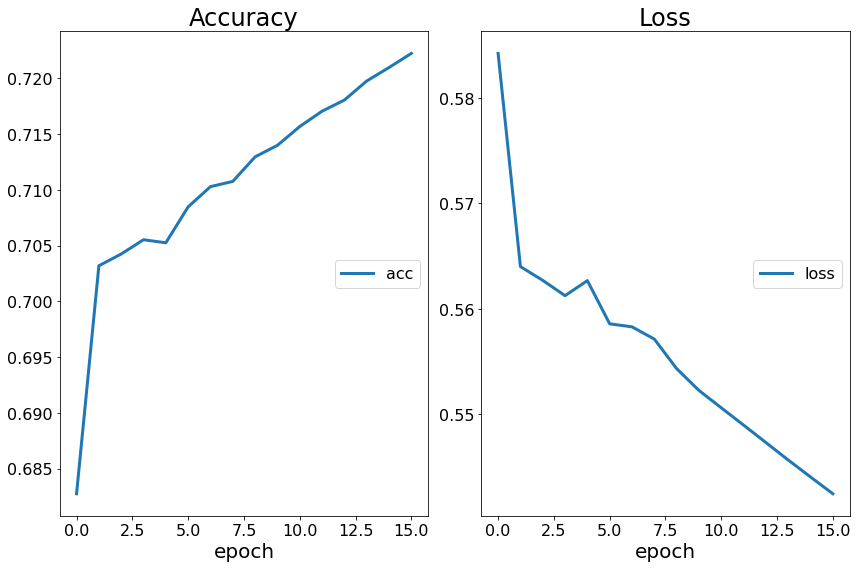

Accuracy
	acc              	 (min:    0.683, max:    0.722, cur:    0.722)
Loss
	loss             	 (min:    0.542, max:    0.584, cur:    0.542)


In [35]:
### Train/tune the model
dataloaders = {"train": train_loader}
optimizer = torch.optim.Adam(eugene.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum') #, pos_weight=torch.tensor(1.3))
top_model, stop_epoch, loss_history, acc_history, _ = project_utils.train_binary_classifier(model=eugene, 
                                                                                            double_stranded="ds" in ARCHITECTURE,
                                                                                            dataloaders=dataloaders, 
                                                                                            device=device,
                                                                                            criterion=criterion, 
                                                                                            optimizer=optimizer, 
                                                                                            num_epoch=MAX_EPOCHS, 
                                                                                            early_stop=True, 
                                                                                            patience=PATIENCE,
                                                                                            plot_frequency=5)

# Validation Set Performance

In [105]:
prob_thresh = 0.5

In [103]:
# Get the best model results
top_model.eval()
y_outputs = {'train': torch.empty(size=(len(X_train), 1)), 'validation': torch.empty(size=(len(X_test), 1))}
y_targets = {}
for phase in ['train', 'validation']:
    len_set = len(dataloaders[phase].dataset)
    for batch, (inputs, _) in enumerate(dataloaders[phase]):
        inputs = inputs.to(device)
        if "ds" in ARCHITECTURE:
            input_forward = inputs[:, :, :, 0].to(device)
            input_reverse = inputs[:, :, :, 1].to(device)
            outputs = top_model(input_forward.float(), input_reverse.float()).detach()
        else:
            inputs = inputs.to(device)
            outputs = top_model(inputs.float()).detach()
        if BATCH_SIZE*(batch+1) < len_set:
            y_outputs[phase][BATCH_SIZE*batch:BATCH_SIZE*(batch+1)] = outputs
        else:
            y_outputs[phase][BATCH_SIZE*batch:len_set] = outputs

y_tr_outs = y_outputs["train"]
y_tr_probs = torch.sigmoid(y_tr_outs).detach().numpy()
y_tr_preds = (y_tr_probs >= prob_thresh).astype(int)
y_outs = y_outputs["validation"]
y_probs = torch.sigmoid(y_outs).detach().numpy()
y_preds = (y_probs >= prob_thresh).astype(int)

In [104]:
# Generate a report
if TUNE:
    iters = EPOCHS_TRAINED + stop_epoch - PATIENCE
else:
    iters = stop_epoch - PATIENCE
project_utils.classification_report(out_path="{}".format(OUTDIR),
                                    train_X=X_train, test_X=X_test, 
                                    train_y=y_train, test_y=y_test,
                                    train_preds=y_tr_preds, test_preds=y_preds,
                                    train_probs=y_tr_probs, test_probs=y_probs,
                                    iters_trained=iters)

Predictions provided, skipping them
Generating confusion matrix
Calculating classification metrics
Metric	Train	Test
Accuracy	0.7416	0.7333
Precision	0.7465	0.7359
Recall	0.6940	0.6817
F0.1-Score	0.7459	0.7353
F0.5-Score	0.7354	0.7244
F1-Score	0.7193	0.7078
F2-Score	0.7039	0.6919
F10-Score	0.6945	0.6822
Plotting PR Curve
Plotting ROC Curve
Generating report


# Save the classifier

In [106]:
torch.save(top_model.state_dict(), "{}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, iters, ARCHITECTURE))

with open("{}/{}_{}_{}_{}-clf_{}.hyperparams.txt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, iters, ARCHITECTURE), "w") as f:
    if "ds" in ARCHITECTURE:
        f.write(str(summary(eugene, input_size=((BATCH_SIZE, 66, 4), (BATCH_SIZE, 66, 4)))))
    else:
        if RECURRENT:
            f.write(str(summary(top_model, input_size=(BATCH_SIZE, 66, 4))) + "\n")
        else:
            f.write(str(summary(top_model, input_size=(BATCH_SIZE, 4, 66))) + "\n")      
    f.write("Loss function: {}".format(criterion.__str__()) + "\n")
    f.write("Positive weight: {}".format(criterion.pos_weight) + "\n")
    f.write("Optimizer params: {}".format(optimizer.defaults.__str__()))

# References

1. Ref 1
2. Ref 1

# Scratch

In [ ]:
# Current livelossplot compatible training script
def train_model(model, criterion, optimizer, num_epoch, early_stop=False, patience=3):
    liveloss = PlotLosses()
    loss_history, acc_history = {}, {}
    if early_stop:
        print("Using early stopping with a patience of {}".format(patience))
        stop = EarlyStop(patience)
        e_stop = False
    for epoch in range(num_epoch):
        logs = {}
        for phase in ['train', 'validation']:

            if phase == 'train' and epoch > 0:
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_acc = 0.0
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                outputs = model(inputs.float())
                targets = targets.unsqueeze(dim=1).to(device)
                loss = criterion(outputs, targets.float())
                if phase == 'train' and epoch > 0:
                    optimizer.zero_grad()
                    loss.backward()                
                    optimizer.step()          
                
                running_loss += loss.item()
                running_acc += project_utils.accuracy(outputs, targets)
            
            len_dataset = len(dataloaders[phase].dataset)
            epoch_loss = running_loss / len_dataset
            epoch_acc = running_acc / len_dataset
                
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'
                if early_stop:
                    e_stop, best_model = stop(epoch_loss, model)
                    
            logs[prefix + 'loss'] = epoch_loss
            logs[prefix + 'acc'] = epoch_acc
            
            loss_history.setdefault(phase, []).append(epoch_loss)
            acc_history.setdefault(phase, []).append(epoch_acc)
            
        liveloss.update(logs)
        liveloss.send()
        if early_stop:
            if e_stop:
                print("Early stopping occured at epoch {}".format(epoch))
                break
        best_model = model
            
    return best_model, epoch, loss_history, acc_history, liveloss